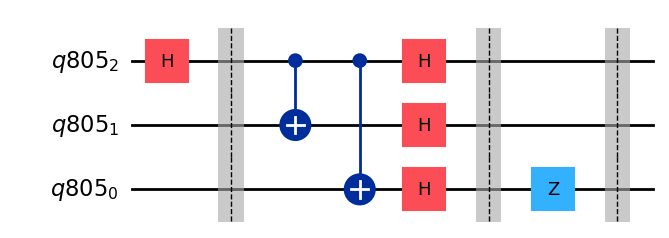

In [246]:
from qiskit import QuantumRegister, QuantumCircuit

qubits = 3
qreg = QuantumRegister(qubits)
qc = QuantumCircuit(qreg)

# note the order of the qubits are reversed in the qiskit
# initialize the state
qc.h(qreg[2])
qc.barrier()
# apply 3-bit repetition code
qc.cx(qreg[2], qreg[1])
qc.cx(qreg[2], qreg[0])
qc.h(qreg[2])
qc.h(qreg[1])
qc.h(qreg[0])
qc.barrier()
# introduce a phase flip error
qc.z(qreg[0])
qc.barrier()

qc.draw(output="mpl", reverse_bits=True)

In [247]:
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.quantum_info import SparsePauliOp

x0x1 = SparsePauliOp(["XXI"])
x1x2 = SparsePauliOp(["IXX"])
estimator = Estimator()
job = estimator.run(
    [
        (qc, x0x1),
        (qc, x1x2),
    ]
)
for i, result in enumerate(job.result()):
    data = result.data
    evs = data.evs
    stds = data.stds
    print(f"Expectation value for x{i}x{i+1}: {evs:.0f}")

Expectation value for x0x1: 1
Expectation value for x1x2: -1


In [262]:
from qiskit import QuantumRegister, QuantumCircuit


def encoding():
    qreg = QuantumRegister(5)
    qc = QuantumCircuit(qreg)
    qc.cx(qreg[-1], qreg[-2])
    qc.cx(qreg[-1], qreg[-3])
    qc.barrier()
    # apply Hadamard gates
    qc.h(qreg[-1])
    qc.h(qreg[-2])
    qc.h(qreg[-3])
    qc.barrier()
    return qc


def phase_synrome():
    qreg = QuantumRegister(5)
    qc = QuantumCircuit(qreg)
    # apply Hadamard gates
    qc.h(qreg[-1])
    qc.h(qreg[-2])
    qc.h(qreg[-3])
    # apply syndrome measurement
    qc.cx(qreg[-1], qreg[1])
    qc.cx(qreg[-2], qreg[1])
    qc.cx(qreg[-2], qreg[0])
    qc.cx(qreg[-3], qreg[0])
    qc.barrier()
    return qc


def decoding():
    qreg = QuantumRegister(5)
    qc = QuantumCircuit(qreg)
    # apply Hadamard gates
    qc.h(qreg[-1])
    qc.h(qreg[-2])
    qc.h(qreg[-3])
    # qc.barrier()
    # apply decoding
    qc.cx(qreg[-1], qreg[-2])
    qc.cx(qreg[-1], qreg[-3])
    qc.ccx(qreg[-3], qreg[-2], qreg[-1])
    qc.barrier()
    return qc

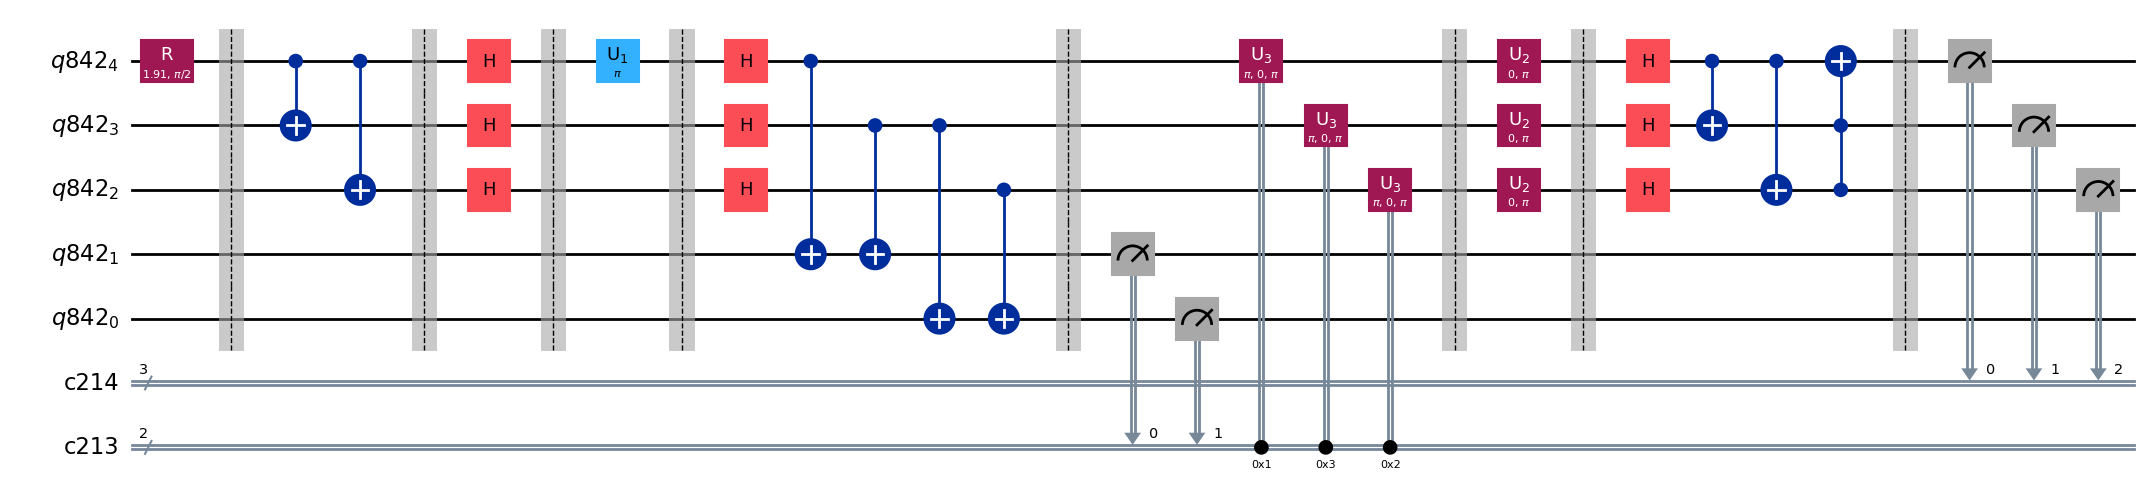

In [263]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import numpy as np

qubits = 3
ancilla = 2
qreg = QuantumRegister(qubits + ancilla)
creg_ancilla = ClassicalRegister(ancilla)
creg_state = ClassicalRegister(qubits)
qc = QuantumCircuit(qreg, creg_ancilla, creg_state)

# note the order of the qubits are reversed in the qiskit
# initialize the state
# qc.h(qreg[-1])
qc.ry(2 * np.arccos(1 / np.sqrt(3)), qreg[-1])
qc.barrier()
# apply encoding
qc.append(encoding(), qreg)
# introduce a phase flip error
qc.z(qreg[-1])
qc.barrier()
# apply syndrome measurement
qc.append(phase_synrome(), qreg)
qc.measure([qreg[1], qreg[0]], creg_ancilla)
# correct the error based on the syndrome
qc.x(qreg[-1]).c_if(creg_ancilla, 1)
qc.x(qreg[-2]).c_if(creg_ancilla, 3)
qc.x(qreg[-3]).c_if(creg_ancilla, 2)
qc.barrier()
qc.h(qreg[-1])
qc.h(qreg[-2])
qc.h(qreg[-3])
qc.barrier()
# apply decoding
qc.append(decoding(), qreg)
# measure the corrected state
qc.measure([qreg[-1], qreg[-2], qreg[-3]], creg_state)

qc.decompose().draw(output="mpl", reverse_bits=True, fold=-1)

In [264]:
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile

simulator = AerSimulator()

# transpile the circuit
qc = transpile(qc, simulator)

# execute the circuit and read the results
job = simulator.run(qc, shots=1024)

counts = job.result().get_counts()
for outcome in counts.keys():
    print(outcome[::-1], "is observed", counts[outcome], "times")

10 000 is observed 345 times
10 100 is observed 679 times
